# Hearbet Sound Anomaly Detector - Training

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchaudio
import torchaudio.transforms as T
from torchmetrics import Precision

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
torch.__version__

'2.1.1+cu121'

In [3]:
torch.cuda.is_available()

True

## Creating Pandas dataframe

In [4]:
AUDIO_DIR = Path('../unzipped_data/')

def list_files():
    for file in AUDIO_DIR.glob('**/*.wav'):
        yield file.as_posix()

def create_dataframe():
    data_files = []
    for filename in list_files():
        if filename.find('artifact')>-1:
            data_files.append((filename, 'artifact'))
        if filename.find('extrahls')>-1:
            data_files.append((filename, 'extrahls'))
        if filename.find('extrastole')>-1:
            data_files.append((filename, 'extrastole'))
        if filename.find('murmur')>-1:
            data_files.append((filename, 'murmur'))
        if filename.find('normal')>-1:
            data_files.append((filename, 'normal'))

    return pd.DataFrame(data_files, columns=('fname', 'label'))

In [5]:
dataframe = create_dataframe()

## Custom Dataset and DataLoaders

In [6]:
labels = dataframe.label.unique()
dict(zip(labels, range(len(labels))))

{'artifact': 0, 'extrahls': 1, 'murmur': 2, 'normal': 3, 'extrastole': 4}

In [7]:
class AudioDataset(Dataset):
    def __init__(self, dataframe: pd.DataFrame, audio_length: float, target_sample_rate: int) -> None:
        self.dataframe = dataframe
        self.audio_length = audio_length
        self.target_sample_rate = target_sample_rate
        self.num_samples = target_sample_rate * audio_length
        self.labels = dataframe['label'].values
        self.filenames = dataframe['fname'].values
        self.class_indices = {'artifact': 0, 'extrahls': 1, 'murmur': 2, 'normal': 3, 'extrastole': 4}
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, index) -> dict:
        waveform, sample_rate = torchaudio.load(self.filenames[index])
        waveform = torch.mean(waveform, axis=0)
        
        if sample_rate!=self.target_sample_rate:
            resampler = T.Resample(sample_rate, self.target_sample_rate)
            waveform = resampler(waveform)
        
        if waveform.shape[0] > self.num_samples:
            waveform = waveform[:self.num_samples]
        else:
            waveform = F.pad(waveform, (0, self.num_samples - waveform.shape[0]))
        melspectrgoram = T.MelSpectrogram(n_fft=128, n_mels=128, hop_length=128)
        melspec = melspectrgoram(waveform)
        
        class_idx = self.class_indices[self.labels[index]]
        
        return torch.stack([melspec]), class_idx

In [8]:
SEED: int = 42
AUDIO_LENGTH: int = 15
TARGET_SAMPLE_RATE: int = 4000

audio_dataset = AudioDataset(dataframe, AUDIO_LENGTH, TARGET_SAMPLE_RATE)
generator = torch.Generator().manual_seed(SEED)
train_dataset, test_dataset = torch.utils.data.random_split(audio_dataset, [.7, .3], generator)

In [9]:
print('Train:', len(train_dataset.indices), '-- Test:', len(test_dataset.indices))

Train: 410 -- Test: 175


## Training

### Architecture

In [51]:
# NUM_CLASSES: 5
# INPUT_SHAPE: (128, 469, 1)

class Network(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(3, 4)),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=(2, 3), stride=(2, 3)),
            nn.ReLU()
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(3, 4)),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=(2, 3), stride=(2, 3)),
            nn.ReLU()
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=(3, 4)),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.dense_layers = nn.Sequential(
            nn.Linear(64*28*47, 100),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(100, 5)
        )

    def forward(self, X):
        X = self.conv_block1(X)
        X = self.conv_block2(X)
        X = self.conv_block3(X)
        X = X.view(-1, 64*28*47)
        X = self.dense_layers(X)
        return X

In [52]:
print(Network())

Network(
  (conv_block1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 4), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=(2, 3), stride=(2, 3), padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
  )
  (conv_block2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 4), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=(2, 3), stride=(2, 3), padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
  )
  (conv_block3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 4), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (dense_layers): Sequential(
    (0): Linear(in_features=84224, out_features=100, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=100, out_features=5, bias=True)
  )


### Training model

In [53]:
from typing import Callable, Dict, List, Tuple

class HearbetDetectorTrainer:
    def __init__(self, model, lr: float, device: str) -> None:
        self.__device = device
        self.__optimizer = torch.optim.SGD(params = model.parameters(), lr=lr)
        self.__precision_fn: Callable = Precision(task = 'multiclass', num_classes = 5).to(device)
        self.__model = model.to(device)
        self.__model.apply(self.__init_weights)

    def __init_weights(self, module) -> None:
        if isinstance(module, (nn.Linear, nn.Conv2d)):
            torch.nn.init.xavier_uniform_(module.weight)
            module.bias.data.fill_(0.01)

    def __get_report_by_epoch(self, *args) -> None:
        print('Epoch: {} | Loss: {:.4f} - Precision: {:.4f} --- Val loss: {:.4f} - Val precision: {:.4f}'.format(*args))

    def __get_loaders(self, training_set, validation_set, batch_size: int) -> Tuple:
        train_loader = DataLoader(training_set, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(validation_set, batch_size=batch_size)
        return train_loader, val_loader

    def fit(self, loss_function, epochs: int, batch_size: int, training_set, validation_set) -> Dict[str, List]:

        train_loader, val_loader = self.__get_loaders(training_set, validation_set, batch_size)

        print('Training on', self.__device)

        history_loss, history_val_loss, history_precision, history_val_precision = [], [], [], []

        for epoch in range(epochs):
            train_loss, train_precision = 0, 0

            self.__model.train()

            for specs, labels in train_loader:
                specs, labels = specs.to(self.__device), labels.to(self.__device)

                outputs = self.__model(specs)

                loss = loss_function(outputs, labels)
                train_loss += loss.item()
                train_precision += self.__precision_fn(outputs, labels).item()

                self.__optimizer.zero_grad()
                loss.backward()
                self.__optimizer.step()

            self.__model.eval()
            with torch.inference_mode():

                val_precision, val_loss = 0, 0

                for specs, labels in val_loader:
                    specs, labels = specs.to(self.__device), labels.to(self.__device)
                    outputs = self.__model(specs)
                    loss = loss_function(outputs, labels)
                    val_loss += loss.item()
                    val_precision += self.__precision_fn(outputs, labels).item()

            length_train_loader, length_val_loader = len(train_loader), len(val_loader)
            loss_per_epoch: float = train_loss/length_train_loader
            precision_per_epoch: float = train_precision/length_train_loader
            val_loss_per_epoch: float = val_loss/length_val_loader
            val_precision_per_epoch: float = val_precision/length_val_loader

            history_loss.append(loss_per_epoch)
            history_precision.append(precision_per_epoch)
            history_val_loss.append(val_loss_per_epoch)
            history_val_precision.append(val_precision_per_epoch)

            self.__get_report_by_epoch(epoch + 1,
                                       loss_per_epoch,
                                       precision_per_epoch,
                                       val_loss_per_epoch,
                                       val_precision_per_epoch)

        return {
            'loss': history_loss,
            'precision': history_precision,
            'val_loss': history_val_loss,
            'val_precision': history_val_precision
        }

    def predict(self, X):
        return self.__model(X)

Calculating weights to fix unbalanced classes:

In [54]:
train_df = dataframe.iloc[train_dataset.indices]
weights = round(len(train_df)/(5*train_df.label.value_counts()), 2)
print(weights)
list(weights.values)

label
normal        0.34
murmur        0.85
extrastole    2.83
artifact      2.93
extrahls      5.86
Name: count, dtype: float64


[0.34, 0.85, 2.83, 2.93, 5.86]

In [55]:
%%time

device: str = 'cuda' if torch.cuda.is_available() else 'cpu'

hearbetDetectorNetwork = HearbetDetectorTrainer(Network(), lr = 0.0001, device = device)

class_weights = torch.tensor([0.34, 0.85, 2.83, 2.93, 5.86]).to(device)

EPOCHS = 30

history = hearbetDetectorNetwork.fit(nn.CrossEntropyLoss(),
                                     epochs = EPOCHS,
                                     batch_size = 4,
                                     training_set = train_dataset,
                                     validation_set = test_dataset)

Training on cuda


c:\Users\Erick\miniconda3\envs\heartbet-sound-anomaly-detector-py311\Lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (65) may be set too low.
  warnings.warn(


Epoch: 1 | Loss: 1.3161 - Precision: 0.5121 --- Val loss: 1.2696 - Val precision: 0.6326
Epoch: 2 | Loss: 0.9862 - Precision: 0.6383 --- Val loss: 1.2583 - Val precision: 0.6439
Epoch: 3 | Loss: 0.8911 - Precision: 0.6869 --- Val loss: 1.1238 - Val precision: 0.6269
Epoch: 4 | Loss: 0.8050 - Precision: 0.7136 --- Val loss: 1.1437 - Val precision: 0.6212
Epoch: 5 | Loss: 0.7704 - Precision: 0.7209 --- Val loss: 1.1237 - Val precision: 0.6667
Epoch: 6 | Loss: 0.7560 - Precision: 0.7379 --- Val loss: 1.2069 - Val precision: 0.6780
Epoch: 7 | Loss: 0.7014 - Precision: 0.7573 --- Val loss: 1.1920 - Val precision: 0.6723
Epoch: 8 | Loss: 0.6769 - Precision: 0.7816 --- Val loss: 1.1964 - Val precision: 0.6269
Epoch: 9 | Loss: 0.6571 - Precision: 0.7961 --- Val loss: 1.1565 - Val precision: 0.6553
Epoch: 10 | Loss: 0.5924 - Precision: 0.8058 --- Val loss: 1.1881 - Val precision: 0.6553
Epoch: 11 | Loss: 0.6130 - Precision: 0.7985 --- Val loss: 1.1954 - Val precision: 0.6553
Epoch: 12 | Loss: 0

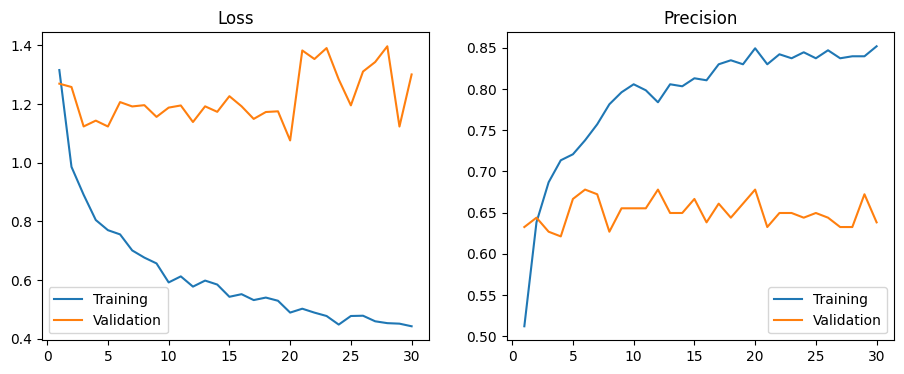

In [56]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))

epochs = range(1, EPOCHS + 1)

ax1.set_title('Loss')
ax1.plot(epochs, history['loss'], label='Training')
ax1.plot(epochs, history['val_loss'], label='Validation')
ax1.legend()

ax2.set_title('Precision')
ax2.plot(epochs, history['precision'], label='Training')
ax2.plot(epochs, history['val_precision'], label='Validation')
ax2.legend()